# Learning to optimize a set of 2D parametric nonlinear programming problems (pNLP) using Neuromancer.


This is an interactive notebook based on the python script [Part_3_LearnToOptimize_pNLP.py](./Part_3_LearnToOptimize_pNLP.py).  

Problem formulation:
$$
    \begin{align}
    &\text{minimize } &&   f\\
    &\text{subject to} && \left(\frac{p}{2}\right)^2 \le x^2 + y^2 \le p^2\\
    & && x \ge y
    \end{align}
$$


problem parameters:             $p$,  
problem decition variables:     $x, y$,  
Search domain:                  $-5.0 \le x, y \le 5.0$

Set of objective functions f:  
Rosenbrock:$ \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,    f = (1 - x)^2 + (y - x^2)^2$  
GomezLevy:$  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,      f = 4x^2 - 2.1x^4 + 1/3x^6 + xy - 4y^2 + 4y^4$  
Himelblau:$  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  f = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$  
Styblinski-Tang:$  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, f = x^4 -15x^2 + 5x + y^4 -15y^2 + 5y$  
Simionescu:$     \,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \,\,\,\,\,\,\,\,  f = 0.1xy$  
McCormick:$       \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, f = sin(x + y) + (x - y)^2 - 1.5x + 2.5y +1$  
Three-hump-camel:$  \,\,\,\,\,\,\, f = 2x^2 - 1.05x^4 + (x^6)/6 + xy + y^2$  
Beale:$               \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, 
   f = (1.5 - x + xy)^2 + (2.25 -x + xy^2)^2 + (2.625 -x + xy^3)^2$  

See the description of the test problems here:  
https://en.wikipedia.org/wiki/Test_functions_for_optimization  
https://en.wikipedia.org/wiki/Rosenbrock_function  
https://en.wikipedia.org/wiki/Himmelblau%27s_function  

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [1]:
!pip install neuromancer

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1


*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

### Import

In [1]:
import torch
import torch.nn as nn
import numpy as np 
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from casadi import *
import casadi

In [2]:
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss, BarrierLoss, AugmentedLagrangeLoss
from neuromancer.modules import blocks
from neuromancer.system import Node
import neuromancer.arg as arg

## Dataset

In [3]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed)

Randomly sample parameters from a uniform distribution: $0.5\le p\le6.0$

In [4]:
nsim = 5000  # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = 0.5, 6.0
samples_train = {"p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)

## pNLP Formulation in NeuroMANCER

### Primal Solution Map Architecture

In [5]:
n_hidden = 80                    # Number of hidden states of the solution map
n_layers = 4                     # Number of hidden layers of the solution map
# define neural architecture for the solution map
func = blocks.MLP(insize=1, outsize=2,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[n_hidden] * n_layers )
# define symbolic solution map with concatenated features (problem parameters)
sol_map = Node(func, ['p'], ['x'], name='map')

### Objective and Constraints in NeuroMANCER

In [6]:
"""
variable is a basic symbolic abstraction in Neuromancer
   x = variable("variable_name")                      (instantiates new variable)  
variable construction supports:
   algebraic expressions:     x**2 + x**3 + 5     (instantiates new variable)  
   slicing:                   x[:, i]             (instantiates new variable)  
   pytorch callables:         torch.sin(x)        (instantiates new variable)  
   constraints definition:    x <= 1.0            (instantiates Constraint object) 
   objective definition:      x.minimize()        (instantiates Objective object) 
to visualize computational graph of the variable use x.show() method          
"""

# define weights for objective terms and constraints
Q = 1.0                          # loss function weight
Q_con = 100.0                    # constraints penalty weight

# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p = variable('p')

# list of nonlinear objective functions defined using Neuromancer variable
obj_opt = {'Rosenbrock': (1 - x)**2 + (y - x**2)**2,
           'GomezLevy': 4 * x ** 2 - 2.1 * x ** 4 + 1 / 3 * x ** 6 + x * y - 4 * y ** 2 + 4 * y ** 4,
           'Himelblau': (x**2 + y - 11)**2 + (x + y**2 - 7)**2,
           'Styblinski-Tang': x**4 -15*x**2 + 5*x + y**4 -15*y**2 + 5*y,
           'Simionescu': 0.1*x*y,
           'McCormick': torch.sin(x + y) + (x - y)**2 - 1.5*x + 2.5*y +1,
           'Three-hump-camel': 2*x**2 - 1.05*x**4 + (x**6)/6 + x*y + y**2,
           'Beale': (1.5 - x + x*y)**2 + (2.25 -x + x*y**2)**2 + (2.625 -x + x*y**3)**2 }

# select objective function
obj_fun = 'Himelblau'            # objective function to be optimized 
                                 #     obj_fun choices = ['Rosenbrock', 'GomezLevy', 'Himelblau', 'Styblinski-Tang', 
                                 #     'Simionescu', 'McCormick', 'Three-hump-camel', 'Beale'] 
f = obj_opt[obj_fun]
obj = f.minimize(weight=Q, name='obj')

# define constraints
con_1 = Q_con*(x >= y)
con_2 = Q_con*((p/2)**2 <= x**2+y**2)
con_3 = Q_con*(x**2+y**2 <= p**2)
con_1.name = 'c1'
con_2.name = 'c2'
con_3.name = 'c3'

# lists of objective terms, constraints, and trainable components
objectives = [obj]
constraints = [con_1, con_2, con_3]
components = [sol_map]

In [7]:
# choose loss function type for optimization
loss = 'penalty'                 # type of the loss function
                                 #     loss choices = ['penalty', 'augmented_lagrange', 'barrier']
barrier_type = 'log10'           # type of the barrier function to be used if loss = 'barrier' 
                                 #     barrier_type choices = ['log', 'log10', 'inverse']

if loss == 'penalty':                        # penalty method
    loss = PenaltyLoss(objectives, constraints)
elif loss == 'barrier':                      # barrier method
    loss = BarrierLoss(objectives, constraints, barrier=barrier_type)
elif loss == 'augmented_lagrange':           # augmented Lagrangian method
    optimizer_args = {'inner_loop': 1, "eta": 0.99, 'sigma': 2.0, 'mu_init': 1., "mu_max": 1000.}
    loss = AugmentedLagrangeLoss(objectives, constraints, train_data, **optimizer_args)

# construct constrained optimization problem
problem = Problem(components, loss)

## Parametric Problem Solution in NeuroMANCER

In [8]:
lr = 0.001      # step size for gradient descent
epochs = 400    # number of training epochs
warmup = 100    # number of epochs to wait before enacting early stopping policy
patience = 100  # number of epochs with no improvement in eval metric to allow before early stopping

In [9]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup)

In [10]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 98.95836639404297
epoch: 1  train_loss: 45.295928955078125
epoch: 2  train_loss: 43.998626708984375
epoch: 3  train_loss: 43.30885314941406
epoch: 4  train_loss: 43.359214782714844
epoch: 5  train_loss: 41.258941650390625
epoch: 6  train_loss: 41.997501373291016
epoch: 7  train_loss: 42.43018341064453
epoch: 8  train_loss: 40.325157165527344
epoch: 9  train_loss: 41.09640884399414
epoch: 10  train_loss: 40.832454681396484
epoch: 11  train_loss: 40.66997528076172
epoch: 12  train_loss: 41.23598098754883
epoch: 13  train_loss: 40.587520599365234
epoch: 14  train_loss: 40.235626220703125
epoch: 15  train_loss: 40.661170959472656
epoch: 16  train_loss: 40.53839111328125
epoch: 17  train_loss: 41.11820983886719
epoch: 18  train_loss: 40.79458999633789
epoch: 19  train_loss: 40.03028106689453
epoch: 20  train_loss: 39.86722946166992
epoch: 21  train_loss: 39.55671691894531
epoch: 22  train_loss: 39.47555160522461
epoch: 23  train_loss: 40.33986282348633
epoch: 24  train

<All keys matched successfully>

## Get pNLP solution from CasADi for comparison

[CasADi](https://web.casadi.org/) is an open-source tool for constrained optimization and optimal control that has influenced the development of NeuroMANCER.

In [11]:
# instantiate casadi optimizaiton problem class
opti = casadi.Opti()
# define variables
x = opti.variable()
y = opti.variable()
p_opti = opti.parameter()
# CasADi formulation of objectives
obj_opt_cas = {'Rosenbrock': (1 - x) ** 2 + (y - x ** 2) ** 2,
               'GomezLevy': 4 * x ** 2 - 2.1 * x ** 4 + 1 / 3 * x ** 6 + x * y - 4 * y ** 2 + 4 * y ** 4,
               'Himelblau': (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2,
               'Styblinski-Tang': x ** 4 - 15 * x ** 2 + 5 * x + y ** 4 - 15 * y ** 2 + 5 * y,
               'Simionescu': 0.1 * x * y,
               'McCormick': np.sin(x + y) + (x - y) ** 2 - 1.5 * x + 2.5 * y + 1,
               'Three-hump-camel': 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2,
               'Beale': (1.5 - x + x * y) ** 2 + (2.25 - x + x * y ** 2) ** 2 + (2.625 - x + x * y ** 3) ** 2}
f = obj_opt_cas[obj_fun]
opti.minimize(f)
# define objective and constraints
opti.subject_to(x >= y)
opti.subject_to((p_opti / 2) ** 2 <= x ** 2 + y ** 2)
opti.subject_to(x ** 2 + y ** 2 <= p_opti ** 2)
# select IPOPT solver and solve the NLP
opti.solver('ipopt')

In [12]:
# set parametric value and solve a single instance NLP problem via CasADi
p = 3.
opti.set_value(p_opti, p)
opti.solve()
# solve NLP instance via CasADi
sol = opti.solve()
print('CasADi solution:')
print(sol.value(x))
print(sol.value(y))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [13]:
# solve NLP instance via Neuromancer
datapoint = {'p': torch.tensor([[p]]), 'name': 'test'}
model_out = problem(datapoint)
x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
print('Neuromancer solution:')
print(x_nm)
print(y_nm)

Neuromancer solution:
2.6294835
1.4328706


## Visual comparison: NeuroMANCER vs. CasADi

C:\Users\drgon\AppData\Local\Temp\ipykernel_56028\2986408025.py:23: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  plt.setp(cg1.collections,
C:\Users\drgon\AppData\Local\Temp\ipykernel_56028\2986408025.py:26: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  plt.setp(cg2.collections,
C:\Users\drgon\AppData\Local\Temp\ipykernel_56028\2986408025.py:29: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  plt.setp(cg3.collections,


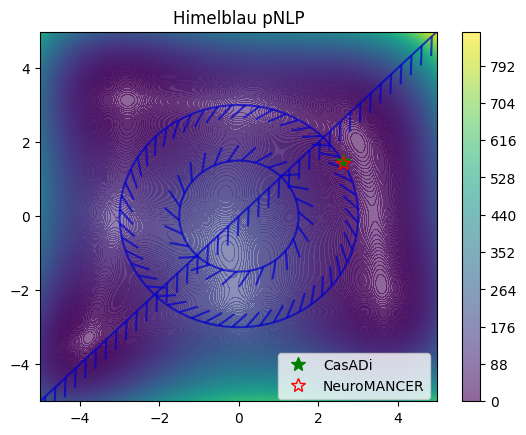

In [14]:
x1 = np.arange(-5., 5., 0.02)
y1 = np.arange(-5., 5., 0.02)
xx, yy = np.meshgrid(x1, y1)
# eval and plot objective
obj_opt_plot = {'Rosenbrock': (1 - xx) ** 2 + (yy - xx ** 2) ** 2,
               'GomezLevy': 4 * xx ** 2 - 2.1 * xx ** 4 + 1 / 3 * xx ** 6 + xx * yy - 4 * yy ** 2 + 4 * yy ** 4,
               'Himelblau': (xx ** 2 + yy - 11) ** 2 + (xx + yy ** 2 - 7) ** 2,
               'Styblinski-Tang': xx ** 4 - 15 * xx ** 2 + 5 * xx + yy ** 4 - 15 * yy ** 2 + 5 * yy,
               'Simionescu': 0.1 * xx * yy,
               'McCormick': np.sin(xx + yy) + (xx - yy) ** 2 - 1.5 * xx + 2.5 * yy + 1,
               'Three-hump-camel': 2 * xx ** 2 - 1.05 * xx ** 4 + (xx ** 6) / 6 + xx * yy + yy ** 2,
               'Beale': (1.5 - xx + xx * yy) ** 2 + (2.25 - xx + xx * yy ** 2) ** 2 + (2.625 - xx + xx * yy ** 3) ** 2}
J = obj_opt_plot[obj_fun]
fig, ax = plt.subplots(1, 1)
cp = ax.contourf(xx, yy, J, levels=1000, alpha=0.6)
fig.colorbar(cp)
ax.set_title(obj_fun+' pNLP')
# eval  and plot  constraints
c1 = xx - yy
c2 = xx ** 2 + yy ** 2 - (p / 2) ** 2
c3 = -(xx ** 2 + yy ** 2) + p ** 2

cg1 = ax.contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
if hasattr(cg1, 'collections') and cg1.collections:
    plt.setp(cg1.collections,
            path_effects=[patheffects.withTickedStroke()], alpha=0.7)

cg2 = ax.contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
if hasattr(cg2, 'collections') and cg2.collections:
    plt.setp(cg2.collections,
            path_effects=[patheffects.withTickedStroke()], alpha=0.7)

cg3 = ax.contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
if hasattr(cg3, 'collections') and cg3.collections:
    plt.setp(cg3.collections,
            path_effects=[patheffects.withTickedStroke()], alpha=0.7)

# plot optimal solutions CasADi vs Neuromancer
ax.plot(sol.value(x), sol.value(y), 'g*', markersize=10, label='CasADi')
ax.plot(x_nm, y_nm, 'r*', fillstyle='none', markersize=10, label='NeuroMANCER')
plt.legend(bbox_to_anchor=(1.0, 0.15))
plt.show(block=True)
